In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

In [2]:
from ipfx.feature_extractor import (SpikeFeatureExtractor, SpikeTrainFeatureExtractor)
import ipfx.stimulus_protocol_analysis as spa
from ipfx.epochs import get_stim_epoch
from ipfx.dataset.create import create_ephys_data_set
from ipfx.utilities import drop_failed_sweeps
from ipfx.data_set_features import extract_data_set_features
from ipfx.error import FeatureError

import os
import matplotlib.pyplot as plt

In [3]:
ontology_path = "./data/stim_ontology_new_Homeira.json"
results_path = Path('./results')
results_path.mkdir(exist_ok=True, parents=True)

In [4]:
t1 = './data/processed/recordings/human/natcom/2019_11_26_0094.nwb'
t2 = './data/processed/recordings/human/h2019/19o10010.nwb'
t3_m = './data/processed/recordings/mouse/m2019/19o23039.nwb'

stim_start_time = 0.0921
stim_end_time = 0.69205

In [5]:
recordings_to_plot = [t1, t2, t3_m]
titles = ['Human L5 in aCSF', 'Human L5 w/ synaptic blockers', 'Mouse L5 w/ synaptic blockers']

In [6]:
def plot_nwb_QC(nwb_list, titles_list, ontology, stim_start_time, stim_end_time, baseline_interval=0.0001, subthresh_min_amp=-100.0, save_path = None):
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(8,8))

    for n, (nwb_path, title) in enumerate(zip(nwb_list, titles_list)):
        data_set = create_ephys_data_set(nwb_file=nwb_path, ontology=ontology)  # loads nwb file into ipfx data structure
        cell_features, sweep_features, cell_record, sweep_records, _, _ = extract_data_set_features(data_set)
        long_square_table = data_set.filtered_sweep_table(stimuli=data_set.ontology.long_square_names)
        long_square_sweeps = data_set.sweep_set(long_square_table.sweep_number)
        long_square_sweeps = data_set.sweep_set()

        # Select epoch corresponding to the actual recording from the sweeps
        # and align sweeps so that the experiment would start at the same time
        long_square_sweeps.select_epoch("recording")

        # build the extractors
        spfx = SpikeFeatureExtractor(start=stim_start_time, end=stim_end_time, filter = 1)
        sptfx = SpikeTrainFeatureExtractor(start=stim_start_time, end=stim_end_time, baseline_interval=baseline_interval)

        # run the analysis and print out a few of the features
        long_square_analysis = spa.LongSquareAnalysis(spfx, sptfx, subthresh_min_amp=subthresh_min_amp)
        lsa_results = long_square_analysis.analyze(long_square_sweeps) 
        
        rheobase_sweep_index = lsa_results['rheobase_sweep'].name
        final_sweep_index = long_square_sweeps.sweep_number[-1]
    
        sweeps_to_plot = [0, rheobase_sweep_index, 14] #final_sweep_index]
    
        for j, sweep in enumerate(sweeps_to_plot):
            curr_sweep = data_set.sweep_set(sweep).sweeps[0]
            t = curr_sweep.t
            v = curr_sweep.v
            i = curr_sweep.i

            if j == 2:
                axes[n].plot(t, v, alpha=0.5, linewidth=2)
                if n == 2:
                    axes[3].plot(t, i, alpha=0.5, linewidth=2)
            else:
                axes[n].plot(t, v, linewidth=2)
                if n == 2:
                    axes[3].plot(t, i, linewidth=2)

            axes[n].set_xlim(0, 0.8)
            axes[n].axis('on')
            axes[n].set_ylabel("Membrane voltage (mV)")
            axes[n].set_title(f'{title}')

        axes[n].set_ylim(-110, 45)
        
        axes[3].set_ylabel("Injected current (pA)")
        axes[3].set_xlabel("Time (s)")
        axes[3].set_yticks([-300, 100, 400])
        axes[3].spines['top'].set_visible(False)
        axes[3].spines['right'].set_visible(False)
        axes[3].spines['left'].set_visible(False)

    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, facecolor='w', dpi=300)    

In [7]:
# this version of the plot has no border/yaxis on the voltage traces
def plot_nwb_QC2(nwb_list, titles_list, ontology, stim_start_time, stim_end_time, baseline_interval=0.0001, subthresh_min_amp=-100.0, save_path = None):
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(8,8))
    
    for n, (nwb_path, title) in enumerate(zip(nwb_list, titles_list)):
        data_set = create_ephys_data_set(nwb_file=nwb_path, ontology=ontology)  # loads nwb file into ipfx data structure
        cell_features, sweep_features, cell_record, sweep_records, _, _ = extract_data_set_features(data_set)
        long_square_table = data_set.filtered_sweep_table(stimuli=data_set.ontology.long_square_names)
        long_square_sweeps = data_set.sweep_set(long_square_table.sweep_number)
        long_square_sweeps = data_set.sweep_set()

        # Select epoch corresponding to the actual recording from the sweeps
        # and align sweeps so that the experiment would start at the same time
        long_square_sweeps.select_epoch("recording")

        # build the extractors
        spfx = SpikeFeatureExtractor(start=stim_start_time, end=stim_end_time, filter = 1)
        sptfx = SpikeTrainFeatureExtractor(start=stim_start_time, end=stim_end_time, baseline_interval=baseline_interval)

        # run the analysis and print out a few of the features
        long_square_analysis = spa.LongSquareAnalysis(spfx, sptfx, subthresh_min_amp=subthresh_min_amp)
        lsa_results = long_square_analysis.analyze(long_square_sweeps) 
        
        rheobase_sweep_index = lsa_results['rheobase_sweep'].name
        final_sweep_index = long_square_sweeps.sweep_number[-1]
    
        sweeps_to_plot = [0, rheobase_sweep_index, 14] #final_sweep_index]
    
        for j, sweep in enumerate(sweeps_to_plot):
            curr_sweep = data_set.sweep_set(sweep).sweeps[0]
            t = curr_sweep.t
            v = curr_sweep.v
            i = curr_sweep.i

            if j == 2:
                axes[n].plot(t, v, alpha=0.5, linewidth=2)
                if n == 2:
                    axes[3].plot(t, i, alpha=0.5, linewidth=2)
            else:
                axes[n].plot(t, v, linewidth=2)
                if n == 2:
                    axes[3].plot(t, i, linewidth=2)

            axes[n].set_xlim(0, 0.8)
            axes[n].axis('off')
            axes[n].set_ylabel("Membrane voltage (mV)")
            axes[n].set_title(f'{title}')

        axes[n].set_ylim(-110, 45)
        
        axes[3].set_ylabel("Injected current (pA)")
        axes[3].set_xlabel("Time (s)")
        axes[3].set_yticks([-300, 100, 400])
        axes[3].spines['top'].set_visible(False)
        axes[3].spines['right'].set_visible(False)
        axes[3].spines['left'].set_visible(False)
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, facecolor='w', dpi=300)    

In [8]:
recordings_to_plot

['./data/processed/recordings/human/natcom/2019_11_26_0094.nwb',
 './data/processed/recordings/human/h2019/19o10010.nwb',
 './data/processed/recordings/mouse/m2019/19o23039.nwb']

/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]


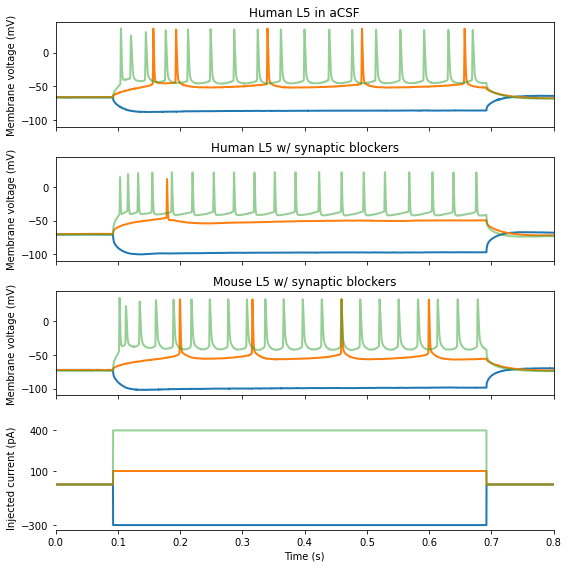

In [9]:
plot_nwb_QC(recordings_to_plot, titles_list=titles , ontology=ontology_path, stim_start_time=stim_start_time, stim_end_time=stim_end_time, save_path='./results/example_traces_w_axis.pdf')

/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]


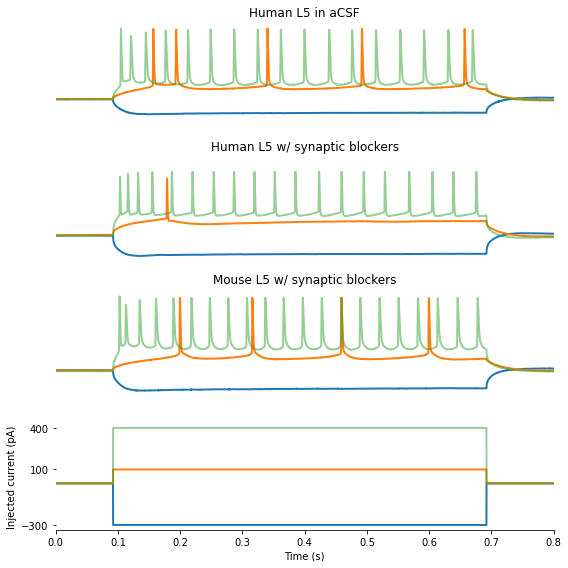

In [10]:
plot_nwb_QC2(recordings_to_plot, titles_list=titles , ontology=ontology_path, stim_start_time=stim_start_time, stim_end_time=stim_end_time, save_path='./results/example_traces_no_axis.pdf' )

## Plotting example trace figure 4

In [9]:
def plot_nwb_fig4(nwb_list, titles_list, ontology, stim_start_time, stim_end_time, baseline_interval=0.0001, subthresh_min_amp=-150.0, save_path = None):
    fig, axes = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(10,4), gridspec_kw={'height_ratios': [1, 0.5]})

    for n, (nwb_path, title) in enumerate(zip(nwb_list, titles_list)):
        data_set = create_ephys_data_set(nwb_file=nwb_path, ontology=ontology)  # loads nwb file into ipfx data structure
        cell_features, sweep_features, cell_record, sweep_records, _, _ = extract_data_set_features(data_set)
        long_square_table = data_set.filtered_sweep_table(stimuli=data_set.ontology.long_square_names)
        long_square_sweeps = data_set.sweep_set(long_square_table.sweep_number)
        long_square_sweeps = data_set.sweep_set()

        # Select epoch corresponding to the actual recording from the sweeps
        # and align sweeps so that the experiment would start at the same time
        long_square_sweeps.select_epoch("recording")

        # build the extractors
        spfx = SpikeFeatureExtractor(start=stim_start_time, end=stim_end_time, filter = 1)
        sptfx = SpikeTrainFeatureExtractor(start=stim_start_time, end=stim_end_time, baseline_interval=baseline_interval)

        # run the analysis and print out a few of the features
        long_square_analysis = spa.LongSquareAnalysis(spfx, sptfx, subthresh_min_amp=subthresh_min_amp)
        lsa_results = long_square_analysis.analyze(long_square_sweeps) 
        
        # only looking at initial hyperpolarizing sweep
        curr_sweep = data_set.sweep_set(0).sweeps[0]
        t = curr_sweep.t
        v = curr_sweep.v
        i = curr_sweep.i

        if n == 0:
            axes[0].plot(t, v, alpha=0.75, linewidth=1, label=title, color='darkviolet')
        else:
            axes[0].plot(t, v, alpha=0.75, linewidth=2, label=title, color='gold')
        if n == 0:
            axes[1].plot(t, i, linewidth=2, color='k')
        
        axes[0].legend(loc="center right")
        axes[0].set_xlim(0, 1.25)
        axes[0].axis('on')
        axes[0].set_xticks([])
        axes[0].spines['top'].set_visible(False)
        axes[0].spines['bottom'].set_visible(False)
        axes[0].spines['right'].set_visible(False)
        axes[0].set_ylabel("Membrane voltage (mV)")
        #axes[n].set_title(f'{title}')
        

        axes[n].set_ylim(-160, -50)
        
        axes[1].set_ylabel("Injected \ncurrent (pA)")
        axes[1].set_xlabel("Time (s)")
        axes[1].set_ylim(-275, 20)
        axes[1].set_yticks([-240, 0])
        axes[1].set_xticks([0, 0.5, 1])
        axes[1].spines['top'].set_visible(False)
        axes[1].spines['right'].set_visible(False)
        axes[1].spines['left'].set_visible(False)

    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, facecolor='w', dpi=300)    

# Example traces for Fig. 4

In [10]:
#L23 examples
recordings_to_plot = ['./data/processed/recordings/human/h2018/18320021.nwb',#'./data/processed/recordings/human/h2018/18426010.nwb', 
                      './data/processed/recordings/human/h2018/18o22020.nwb'] # this one works well
                     #'./data/processed/recordings/human/h2018/18o22001.nwb'] # similar baseline -- but is extreme
# L5 examples
#recordings_to_plot = ['./data/processed/recordings/human/h2018/18201011.nwb',
#                      './data/processed/recordings/human/h2019/19128040.nwb']



titles = ['NMDG', 'Sucrose']

stim_start_time=0.0382
stim_end_time=1.0371
baseline_interval=0.0001

/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_

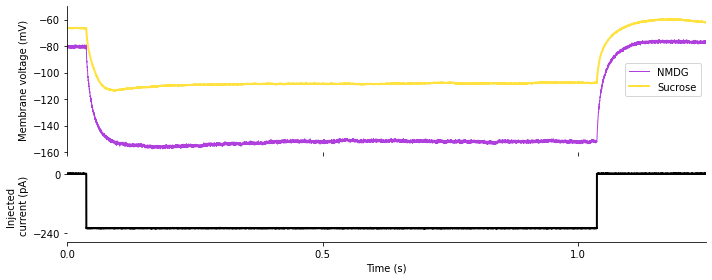

In [11]:
plot_nwb_fig4(recordings_to_plot, titles_list=titles , ontology=ontology_path, stim_start_time=stim_start_time, stim_end_time=stim_end_time, save_path='./results/fig4-example_traces.pdf')